In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import gc
from pathlib import Path
import os

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from IPython.display import FileLink, FileLinks

import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import PIL
from PIL import Image as PIL_IMG

import seaborn as sns

In [104]:
print("Fastai version: ", fastai.__version__)
print("PIL version: ", PIL.__version__)

Fastai version:  1.0.51
PIL version:  5.1.0


In [ ]:
DATA_DIR = Path('../input')
IMGS_PATH = Path('../input/images/images/')
SUB_DIR = Path('dn121_pr/')
SUB_DIR.mkdir(exist_ok=True)

In [105]:
[f for f in DATA_DIR.iterdir()]

[PosixPath('../input/train.csv'),
 PosixPath('../input/sample_submission.csv'),
 PosixPath('../input/images'),
 PosixPath('../input/test.csv')]

In [ ]:
train_df = pd.read_csv(DATA_DIR/'train.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

In [ ]:
train_df['category'] = train_df['category'] + 1

In [ ]:
label_mapper = {1: 'Cargo', 
                2: 'Military', 
                3: 'Carrier', 
                4: 'Cruise', 
                5: 'Tankers'}

In [ ]:
label_mapper_c2i = {v:i for i, v in label_mapper.items()}

In [106]:
label_mapper_c2i

{'Cargo': 1, 'Military': 2, 'Carrier': 3, 'Cruise': 4, 'Tankers': 5}

In [ ]:
train_df['category'] = train_df['category'].map(label_mapper)

In [ ]:
train_df.head()

In [ ]:
train_df['category'].value_counts()

In [107]:
def get_ex(path): return open_image(path)

def plots_f(path, tfms, rows, cols, width, height, **kwargs):
    [get_ex(path).apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())]

In [108]:
tfms = get_transforms(max_rotate=5, xtra_tfms=[])

In [109]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-5, 5)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved=

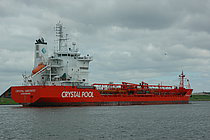

In [110]:
open_image(IMGS_PATH/'2816925.jpg')

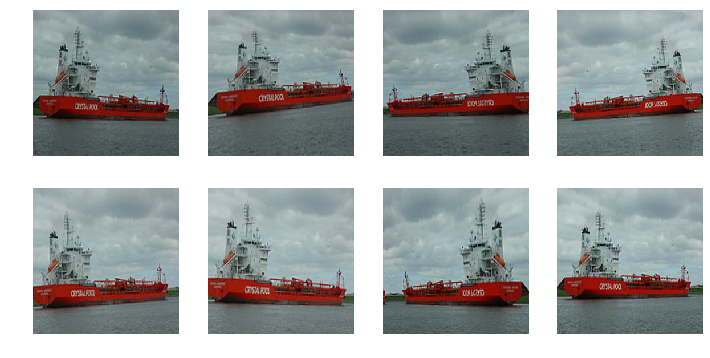

In [111]:
plots_f(IMGS_PATH/'2816925.jpg', tfms, 2, 4, 12, 6, size=(256, 256))
# plots_f(IMGS_PATH/'2816925.jpg', tfms, 2, 4, 12, 6, size=(140, 200), padding_mode='border', resize_method=ResizeMethod.PAD)

In [ ]:
train_il = ImageList.from_df(df=train_df, cols='image', path=IMGS_PATH)
test_il = ImageList.from_df(df=test_df, cols='image', path=IMGS_PATH)

In [ ]:
np.random.seed(0)
src1 = (train_il
        .split_from_df(col='valid')
        .label_from_df(cols='category')
        .add_test(test_il))

In [ ]:
tfms1 = get_transforms(max_rotate=5)
data1 = (src1
        .transform(tfms1, size=(128, 128))
        .databunch(path='.', bs=64)
        .normalize(imagenet_stats))

In [ ]:
data1

In [ ]:
data1.show_batch()

In [ ]:
learn1 = cnn_learner(data1, models.densenet121, metrics=[accuracy, FBeta(average='weighted')])

In [ ]:
learn1.lr_find()

In [ ]:
learn1.recorder.plot()

In [ ]:
dn121_stage1_im128_callbacks = [CSVLogger(learn=learn1, filename=SUB_DIR/'dn121_stage1_im128_history'), ShowGraph(learn=learn1)]

In [ ]:
lr = (1e-2)/2
learn1.fit_one_cycle(8, slice(lr), callbacks=dn121_stage1_im128_callbacks)

In [ ]:
learn1.save('dn121_stage1_im128')

In [ ]:
learn1.unfreeze()
learn1.lr_find()
learn1.recorder.plot()

In [ ]:
dn121_stage2_im128_callbacks = [CSVLogger(learn=learn1, filename=SUB_DIR/'dn121_stage2_im128_history'), ShowGraph(learn=learn1)]

In [ ]:
learn1.fit_one_cycle(16, slice((1e-4), lr/5), callbacks=dn121_stage2_im128_callbacks)

In [ ]:
learn1.save('dn121_stage2_im128')

In [ ]:
from fastai.callbacks.hooks import *
import cv2
import matplotlib.pyplot as plt
import random

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index, learner, imgDataBunch):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, learner, imgDataBunch, classes=['Cargo', 'Carrier', 'Cruise', 'Military', 'Tankers']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = random.randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn1)

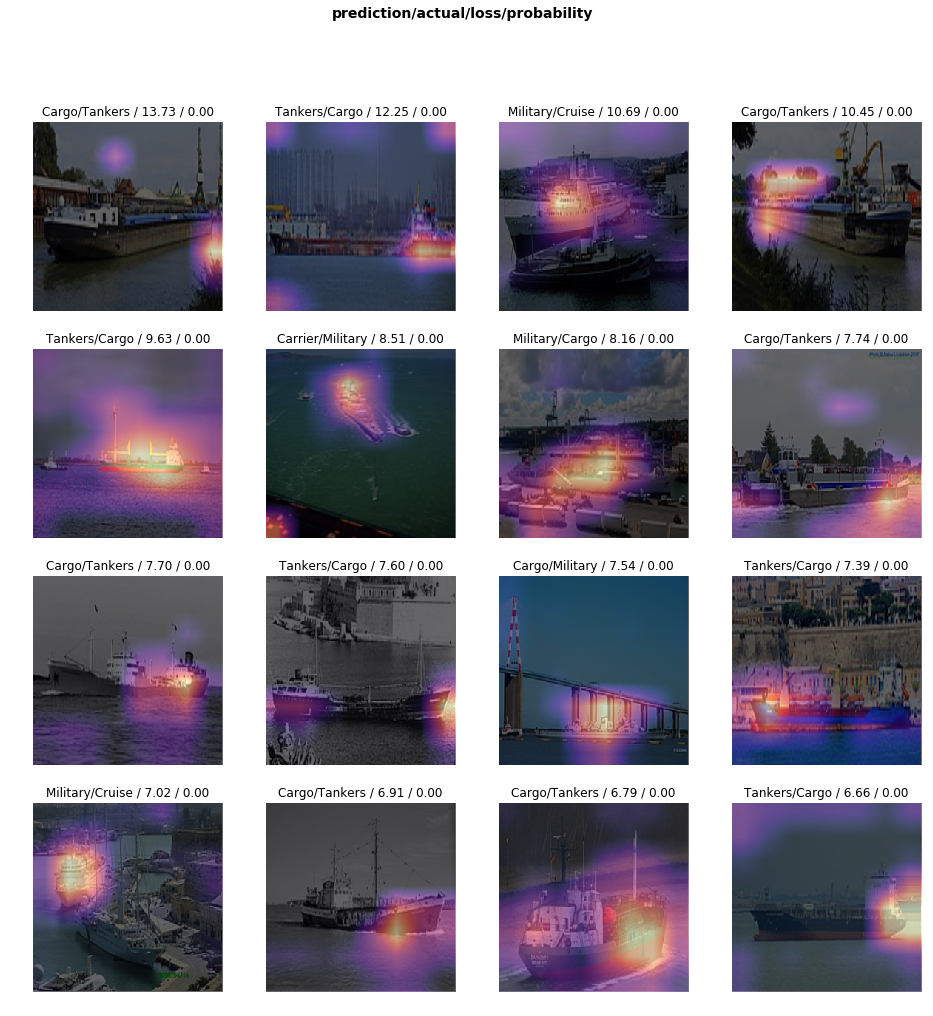

In [112]:
interp.plot_top_losses(16, figsize=(16,16))

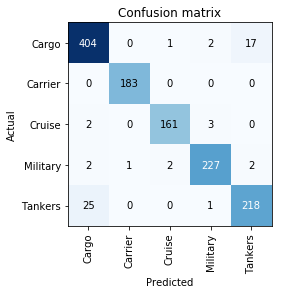

In [113]:
interp.plot_confusion_matrix()

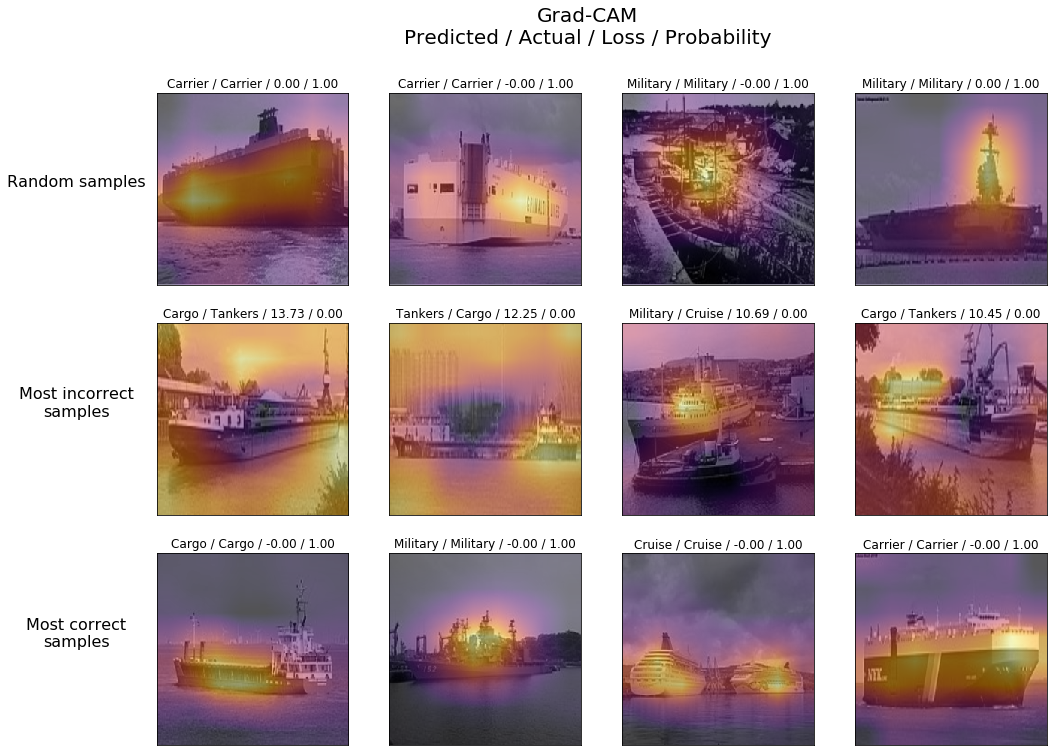

In [114]:
plot_heatmap_overview(interp, learn1, data1)

For 2nd image resolution images

In [ ]:
data2 = (src1
        .transform(tfms1, size=(256, 256))
        .databunch(path='.', bs=32)
        .normalize(imagenet_stats))

In [ ]:
data2.show_batch()

In [ ]:
learn1.data = data2

In [ ]:
learn1.data

In [ ]:
learn1.freeze()
learn1.lr_find()

In [ ]:
learn1.recorder.plot()

In [ ]:
dn121_stage1_im256_callbacks = [CSVLogger(learn=learn1, filename=SUB_DIR/'dn121_stage1_im256_history'), ShowGraph(learn=learn1)]
lr = (1e-2)/2
learn1.fit_one_cycle(15, slice(lr), callbacks=dn121_stage1_im256_callbacks)

In [ ]:
learn1.save('dn121_stage1_im256')

In [ ]:
learn1.unfreeze()
learn1.lr_find()
learn1.recorder.plot()

In [ ]:
dn121_stage2_im256_callbacks = [CSVLogger(learn=learn1, filename=SUB_DIR/'dn121_stage2_im256_history'), ShowGraph(learn=learn1)]
learn1.fit_one_cycle(30, slice((1e-5)/2, (1e-4)/5), callbacks=dn121_stage2_im256_callbacks)

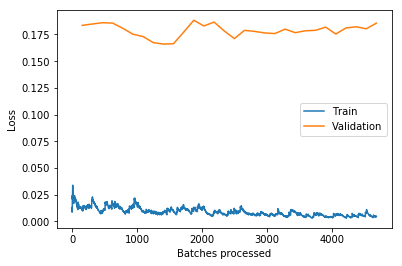

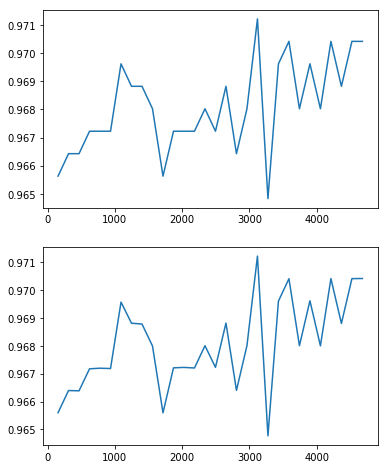

In [118]:
learn1.recorder.plot_losses()
learn1.recorder.plot_metrics()

In [ ]:
learn1.save('dn121_stage2_im256')

In [ ]:
interp2 = ClassificationInterpretation.from_learner(learn1)

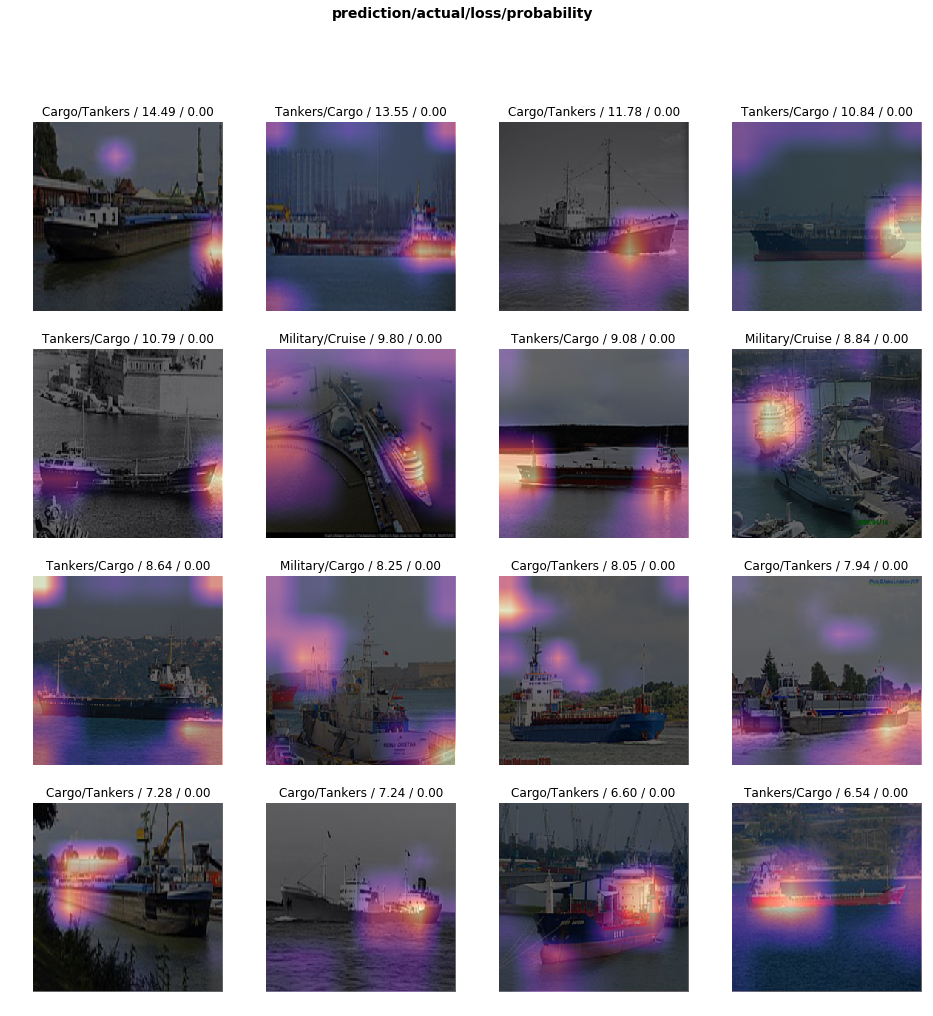

In [119]:
interp2.plot_top_losses(16, figsize=(16,16))

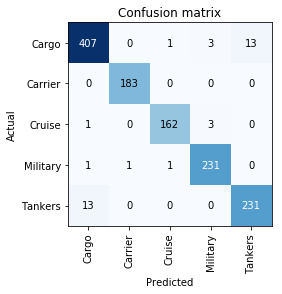

In [120]:
interp2.plot_confusion_matrix()

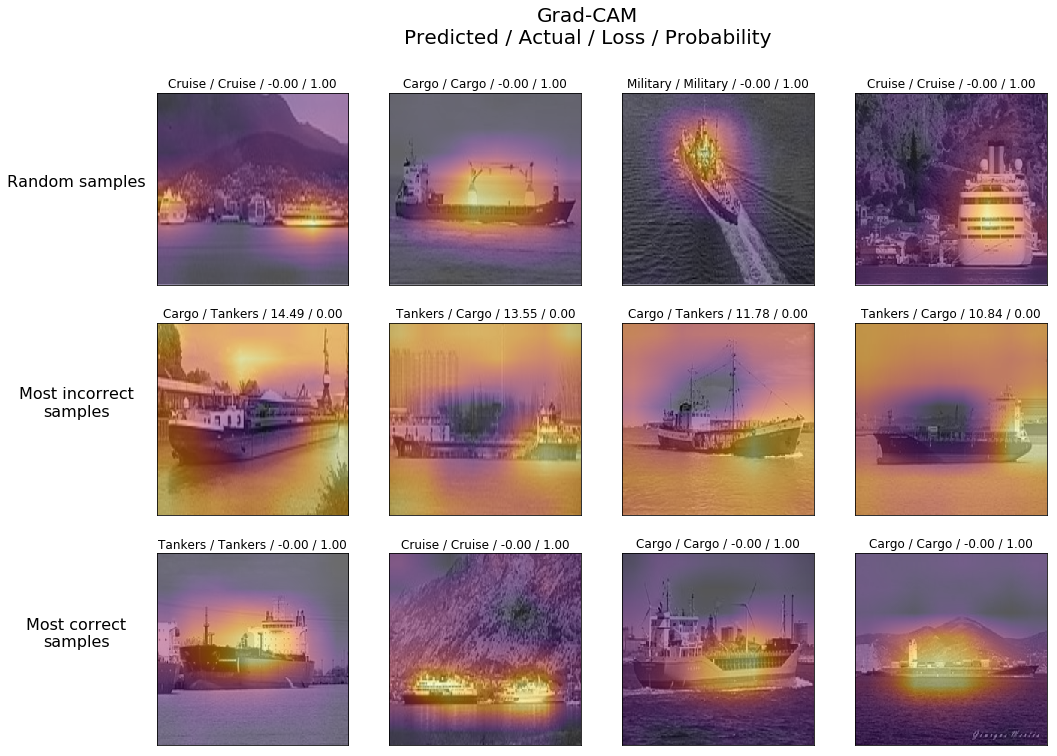

In [121]:
plot_heatmap_overview(interp2, learn1, data2)

In [ ]:
interp2_tta = ClassificationInterpretation.from_learner(learn1, tta=True)

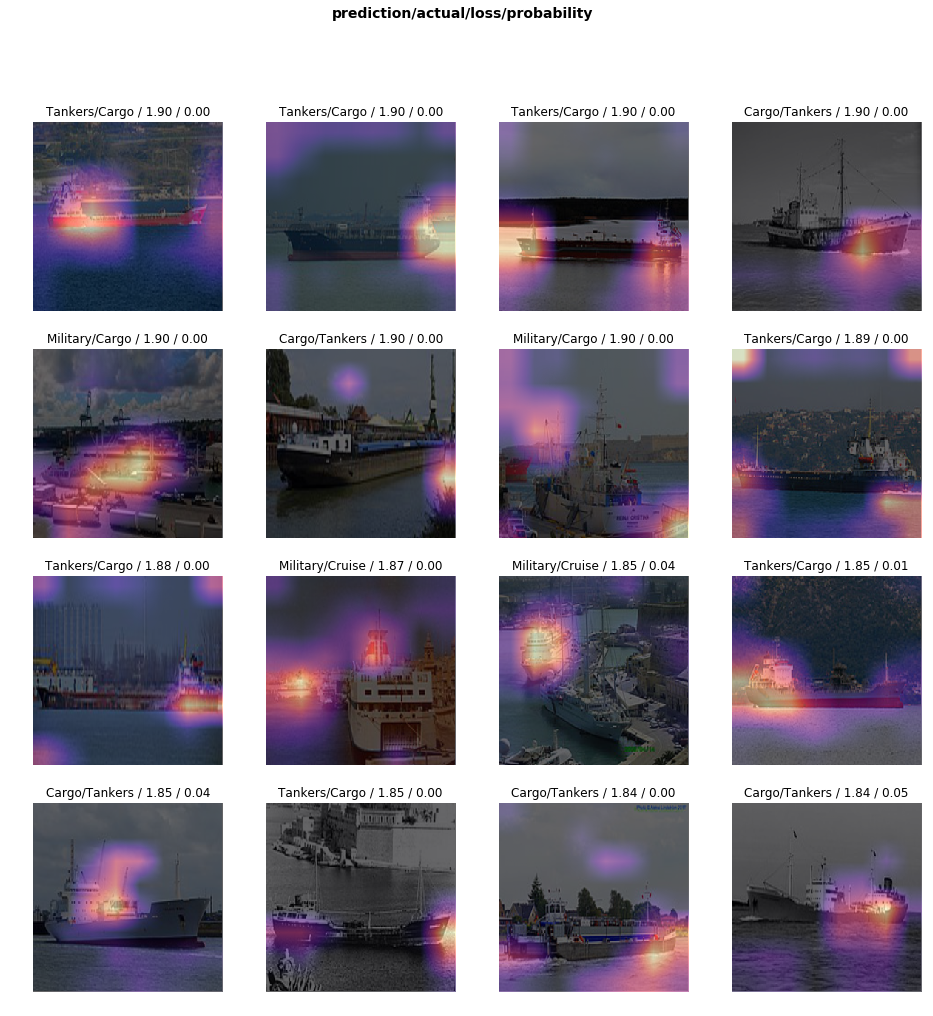

In [122]:
interp2_tta.plot_top_losses(16, figsize=(16,16))

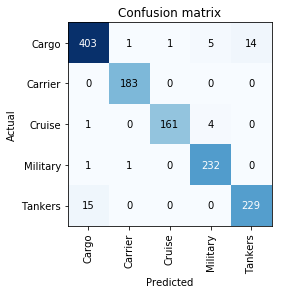

In [123]:
interp2_tta.plot_confusion_matrix()

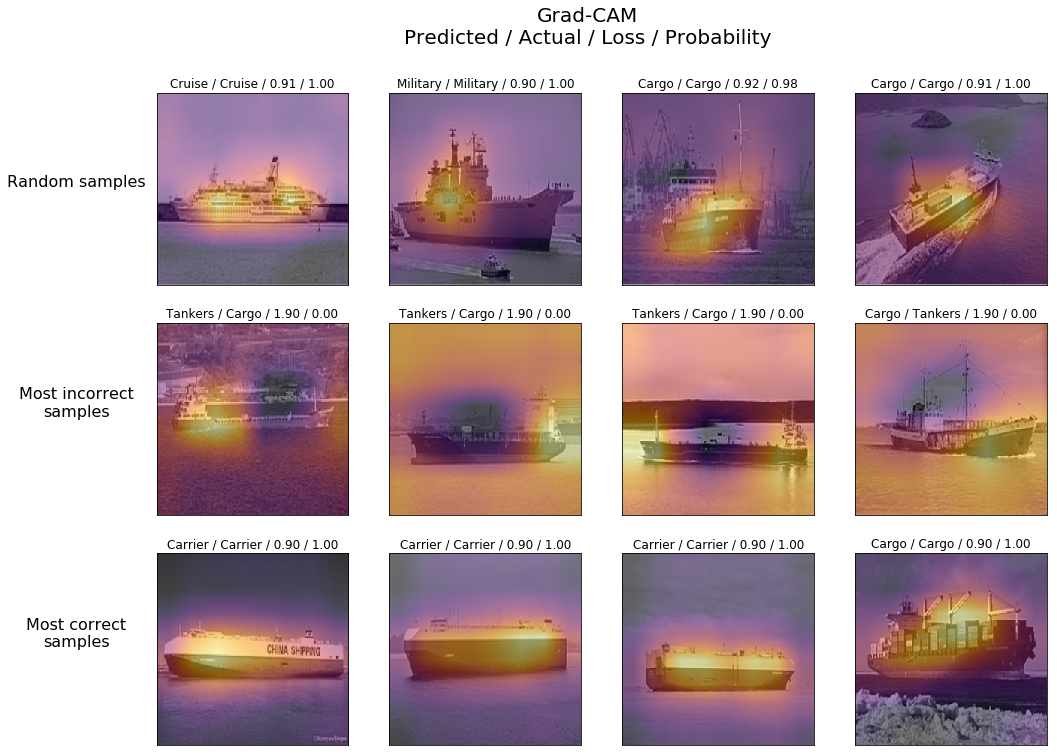

In [124]:
plot_heatmap_overview(interp2_tta, learn1, data2)

In [125]:
fast_i2c = {v:i for i, v in learn1.data.train_ds.y.c2i.items()}

In [126]:
fast_i2c

{0: 'Cargo', 1: 'Carrier', 2: 'Cruise', 3: 'Military', 4: 'Tankers'}

In [ ]:
val_preds_tta = learn1.TTA(ds_type=DatasetType.Valid)

In [127]:
accuracy_score(y_pred=val_preds_tta[0].argmax(1).numpy(), y_true=val_preds_tta[1].numpy())

0.9640287769784173

In [128]:
f1_score(y_pred=val_preds_tta[0].argmax(1).numpy(), y_true=val_preds_tta[1].numpy(), average='weighted')

0.9639408830129815

In [ ]:
val_preds = learn1.get_preds()

In [129]:
accuracy_score(y_pred=val_preds[0].argmax(1).numpy(), y_true=val_preds[1].numpy())

0.9704236610711431

In [130]:
f1_score(y_pred=val_preds[0].argmax(1).numpy(), y_true=val_preds[1].numpy(), average='weighted')

0.9704028920391038

In [ ]:
target_cls = learn1.data.train_ds.y.classes
target_cls

In [ ]:
valid_img_names = [Path(i).name for i in learn1.data.valid_ds.x.items]

In [ ]:
valid_prob_tta_df = pd.DataFrame(val_preds_tta[0].numpy(), columns=target_cls)
valid_prob_tta_df['image'] = valid_img_names

In [ ]:
valid_prob_df = pd.DataFrame(val_preds[0].numpy(), columns=target_cls)
valid_prob_df['image'] = valid_img_names

In [ ]:
train_preds_tta = learn1.TTA(ds_type=DatasetType.Train)

In [131]:
accuracy_score(y_pred=train_preds_tta[0].argmax(1).numpy(), y_true=train_preds_tta[1].numpy())

0.9927884615384616

In [132]:
f1_score(y_pred=train_preds_tta[0].argmax(1).numpy(), y_true=train_preds_tta[1].numpy(), average='weighted')

0.9927902192860331

In [ ]:
train_preds = learn1.get_preds(ds_type=DatasetType.Train)

In [133]:
accuracy_score(y_pred=train_preds[0].argmax(1).numpy(), y_true=train_preds[1].numpy())

1.0

In [134]:
f1_score(y_pred=train_preds[0].argmax(1).numpy(), y_true=train_preds[1].numpy(), average='weighted')

1.0

In [ ]:
test_preds_tta = learn1.TTA(ds_type=DatasetType.Test)

In [ ]:
test_preds = learn1.get_preds(ds_type=DatasetType.Test)

In [ ]:
test_img_names = [Path(i).name for i in learn1.data.test_ds.x.items]

In [ ]:
test_pred_tta_df = pd.DataFrame({'image': test_img_names})
test_pred_tta_df['category'] = test_preds_tta[0].argmax(1).numpy()

In [ ]:
test_pred_df = pd.DataFrame({'image': test_img_names})
test_pred_df['category'] = test_preds[0].argmax(1).numpy()

In [ ]:
test_pred_tta_df['category'] = test_pred_tta_df['category'].map(fast_i2c)
test_pred_tta_df['category'] = test_pred_tta_df['category'].map(label_mapper_c2i).astype(int)

test_pred_df['category'] = test_pred_df['category'].map(fast_i2c)
test_pred_df['category'] = test_pred_df['category'].map(label_mapper_c2i).astype(int)

In [ ]:
test_prob_tta_df = pd.DataFrame(test_preds_tta[0].numpy(), columns=target_cls)
test_prob_tta_df['image'] = test_img_names

test_prob_df = pd.DataFrame(test_preds[0].numpy(), columns=target_cls)
test_prob_df['image'] = test_img_names

In [ ]:
valid_prob_tta_df.to_csv(SUB_DIR/'val_prob_tta.csv', index=False)
valid_prob_df.to_csv(SUB_DIR/'val_prob.csv', index=False)

test_prob_tta_df.to_csv(SUB_DIR/'test_prob_tta.csv', index=False)
test_prob_df.to_csv(SUB_DIR/'test_prob.csv', index=False)

test_pred_tta_df.to_csv(SUB_DIR/'test_pred_tta.csv', index=False)
test_pred_df.to_csv(SUB_DIR/'test_pred.csv', index=False)

In [137]:
FileLinks(SUB_DIR.name)

dn121/
  dn121_stage1_im256_history.csv
  val_prob.csv
  dn121_stage2_im128_history.csv
  test_pred.csv
  dn121_stage2_im256_history.csv
  dn121_stage1_im128_history.csv
  test_pred_tta.csv
  test_prob.csv
  test_prob_tta.csv
  val_prob_tta.csv